In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
palette = 'husl'
sns.set_palette(palette)
from scipy.optimize import minimize
import logging

!pip install keras-tuner -q
import keras_tuner

import pandas_datareader.data as web # for FRED data
from datetime import datetime, date
import holidays
from scipy.optimize import Bounds, LinearConstraint
import warnings
from google.colab import files

!pip install lime
from lime import explanation
from lime import lime_base
from lime.lime_tabular import RecurrentTabularExplainer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
CACHE_PATH='./drive/MyDrive/checkpoints'

Mounted at /content/drive


In [ ]:
# Set constants
TIME_STEP=50
START_DATE = '2005-12-31'
END_DATE = '2023-12-29'
TICKERS = ['DBC','AGG', 'VTI', 'VNQ', 'FXE']
FRED_TICKERS_DICT = {
    'DCOILWTICO': 'wti',  # https://fred.stlouisfed.org/series/DCOILWTICO/
    'T5YIE': 'inflation5y',  # https://fred.stlouisfed.org/series/T5YIE
    'DGS10': 'treasury10y',  # https://fred.stlouisfed.org/series/DGS10
    'VIXCLS': 'vix',  # https://fred.stlouisfed.org/series/VIXCLS/
    'BAMLH0A0HYM2': 'credit_spreads',  # https://fred.stlouisfed.org/series/BAMLH0A0HYM2/
    'FEDFUNDS': 'fedfunds' # Monthly, will be filled forward https://fred.stlouisfed.org/series/fedfunds
}
TRAIN_TEST_SPLIT = 0.80

## Preprocessing

Before doing anything else, we made sure to preserve the chronological sequence of the data by dividing it into a 75%-25% split. Furthermore, we split the  training data into 80%-20%, with the former for training & the latter 20% (representing 15% of the total data) utilized for validation during hyperparameter tuning

### Preprocessing code

In [ ]:
class Preprocessing:
    def __init__(self, tickers: list = TICKERS, time_step: int = 30,
                 start_date: str = START_DATE, end_date: str = END_DATE,
                 train_test_split: float = 0.8,
                 return_horizon: int = 1,  # 1-day returns
                 asset_features: list = ['Close', 'Volume'],
                 features_in_returns: list = ['wti'] + [t+'_Close' for t in TICKERS] + [t+'_Volume' for t in TICKERS],
                 features_in_level_diffs: list = ['inflation5y', 'treasury10y', 'vix', 'credit_spreads'],
                 target_col: str = 'Close',
                 add_external_data: bool = True,
                 keep_weekly_only: bool = False,
                 explanatory_tickers: dict = FRED_TICKERS_DICT):
        self.tickers = tickers
        self.time_step = time_step
        self.start_date = start_date
        self.end_date = end_date
        self.train_test_split = train_test_split
        self.add_external_data = add_external_data
        self.keep_weekly_only = keep_weekly_only
        self.raw_history = {}
        self.return_horizon = return_horizon
        self.asset_features = asset_features
        self.features_in_returns = features_in_returns
        self.features_in_level_diffs = features_in_level_diffs
        self.target_col = target_col
        self.explanatory_tickers = explanatory_tickers

        self.history_train_df = pd.DataFrame()
        self.history_test_df = pd.DataFrame()
        self.risk_free_train = pd.DataFrame()
        self.risk_free_test = pd.DataFrame()
        self.x_train = np.array([])
        self.y_train = np.array([])
        self.x_scaler_train = None
        self.y_scaler_train = None
        self.x_test = np.array([])
        self.y_test = np.array([])
        self.x_scaler_test = None
        self.y_scaler_test = None

    def _import_data(self):
        logging.info('Importing data from Yahoo...')
        self.raw_history = {ticker: yf.Ticker(ticker).history(start=self.start_date, end=self.end_date)
                            for ticker in self.tickers}

    def import_fred_data(self):
        """
        Import economic data from FRED.
        Remove weekends and holidays. Forward fill NAs, useful for instance
        with FedFunds available monthly
        """
        start = datetime.strptime(START_DATE, '%Y-%m-%d')
        end = datetime.strptime(END_DATE, '%Y-%m-%d')
        external_data = web.DataReader(list(self.explanatory_tickers.keys()), "fred", start, end)
        external_data = external_data.rename(columns=self.explanatory_tickers)

        us_holidays = holidays.UnitedStates()
        holiday_filter = [dt not in us_holidays for dt in external_data.index.date]
        external_data = external_data[(external_data.index.weekday < 5)&(holiday_filter)]
        external_data = external_data.fillna(method='ffill').dropna()

        for col in external_data.columns.values:
            if any(x in col for x in self.features_in_returns):
                external_data[col] = np.log(external_data[col]) - np.log(external_data[col].shift(
                    self.return_horizon))
            if any(x in col for x in self.features_in_level_diffs):
                external_data[col] = external_data[col] - external_data[col].shift(
                    self.return_horizon)

        return external_data

    def _preprocess_data(self, history_data, tickers):
        """
        Place all the input data into one data frame. Add log returns
        where the field should be defined in returns. Fill in nulls.
        """
        feat_df = []
        for ticker in tickers:
            ticker_df = history_data[ticker][self.asset_features].copy()
            names_dict = dict(zip(self.asset_features, [f'{ticker}_{ft}' for ft in self.asset_features]))
            ticker_df.rename(columns=names_dict, inplace=True)
            feat_df.append(ticker_df)

        feat_df = pd.concat(feat_df, axis=1)
        feat_df = feat_df.fillna(method='ffill')

        feat_df_incl_ret = feat_df.copy()

        for col in feat_df.columns.values:
            if any(x in col for x in self.features_in_returns) and any(x not in col for x in self.features_in_level_diffs):
                feat_df_incl_ret[col] = np.log(feat_df_incl_ret[col]) - np.log(feat_df_incl_ret[col].shift(
                    self.return_horizon))
            elif any(x in col for x in self.features_in_level_diffs):
                feat_df_incl_ret[col] = feat_df_incl_ret[col] - feat_df_incl_ret[col].shift(
                    self.return_horizon)

        feat_df_incl_ret.dropna(inplace=True)

        feat_df_incl_ret.reset_index(drop=False, inplace=True)
        feat_df_incl_ret['Date'] = pd.to_datetime(feat_df_incl_ret['Date']).dt.date
        feat_df_incl_ret.set_index('Date', inplace=True)

        return feat_df_incl_ret

    def create_x_y_sequences(self, data_df, lookback):
        """
        Creates input sequences for a time series data with a specified lookback window.
        Assumes that y (target) is one of the columns in data_df.
        Transform the data into sequence of lookback length to predict one step forward (y).
        """
        sequences = []
        targets = []
        target_cols = [col for col in data_df.columns.values if self.target_col in col]

        y_data = data_df[target_cols].values
        x_data = data_df.values

        x_scaler = MinMaxScaler(feature_range=(0, 1))
        y_scaler = MinMaxScaler(feature_range=(0, 1))

        x_data = x_scaler.fit_transform(x_data)
        y_data = y_scaler.fit_transform(y_data)

        for i in range(len(data_df) - lookback):
            x_sequence = x_data[i: i + lookback]
            y_target = y_data[i + lookback]
            sequences.append(x_sequence)
            targets.append(y_target)

        return np.array(sequences), np.array(targets), x_scaler, y_scaler

    def run(self):
        """
        Source data if it has not been sourced.
        Split the data into train and test, and standardise.
        Clean and prepare data in the sequence format needed for modelling.
        """
        history_train = {}
        history_test = {}

        if len(self.raw_history) == 0:
            self._import_data()

        # Train Test split
        for ticker, data in self.raw_history.items():
            train_size = int(len(data) * self.train_test_split)
            history_train[ticker], history_test[ticker] = data[:train_size], data[train_size:]

        history_train_clean = self._preprocess_data(history_train, self.tickers)
        history_test_clean = self._preprocess_data(history_test, self.tickers)

        self.history_train_df = history_train_clean
        self.history_test_df = history_test_clean

        # Join with FRED macro data
        if self.add_external_data:
            fred_df = self.import_fred_data()
            self.history_test_df = self.history_test_df.join(fred_df, how='inner').fillna(method='ffill').dropna()
            self.history_train_df = self.history_train_df.join(fred_df, how='inner').fillna(method='ffill').dropna()

            self.risk_free_train = pd.DataFrame(self.history_train_df['fedfunds'][self.time_step:])
            self.risk_free_test = pd.DataFrame(self.history_test_df['fedfunds'][self.time_step:])

        if self.keep_weekly_only: # Where weekday is Friday
            self.history_test_df = self.history_test_df[(self.history_test_df.index.weekday == 4)]
            self.history_train_df = self.history_train_df[(self.history_train_df.index.weekday == 4)]

            if self.add_external_data:
              self.risk_free_train = self.risk_free_train[(self.risk_free_train.index.weekday == 4)]
              self.risk_free_test = self.risk_free_test[(self.risk_free_test.index.weekday == 4)]
        # Prepare modelling sequences of train and test
        self.x_train, self.y_train, self.x_scaler_train, self.y_scaler_train = self.create_x_y_sequences(
            self.history_train_df, self.time_step)
        self.x_test, self.y_test, self.x_scaler_test, self.y_scaler_test = self.create_x_y_sequences(
            self.history_test_df, self.time_step)

        data_struct = {
            'x_train': self.x_train,
            'y_train': self.y_train,
            'x_test': self.x_test,
            'y_test': self.y_test,

            'x_scaler_train': self.x_scaler_train,
            'y_scaler_train': self.y_scaler_train,
            'x_scaler_test': self.x_scaler_test,
            'y_scaler_test': self.y_scaler_test
        }
        return data_struct


### Preprocessing - run

In [ ]:
pp = Preprocessing(
    time_step=TIME_STEP,
    tickers=TICKERS,
    add_external_data=True,
    keep_weekly_only=True,
    explanatory_tickers=FRED_TICKERS_DICT,
    asset_features=['Close', 'Volume'],
    features_in_returns=['wti'] + [t+'_Close' for t in TICKERS] + [t+'_Volume' for t in TICKERS],
    features_in_level_diffs=['inflation5y', 'treasury10y', 'vix', 'credit_spreads'], #'AGG_Close'
    return_horizon=5)

data = pp.run()

X_train = data['x_train']
Y_train = data['y_train']
X_test = data['x_test']
Y_test = data['y_test']

X_scaler_train = data['x_scaler_train']
y_scaler_train = data['y_scaler_train']
X_scaler_test = data['x_scaler_test']
y_scaler_test = data['y_scaler_test']

history_train_clean = pp.history_train_df
history_train_clean.shape

# Extract these indices, will be needed for plotting
test_date_index = pp.history_test_df[TIME_STEP:].index
train_date_index = pp.history_train_df[TIME_STEP:].index

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


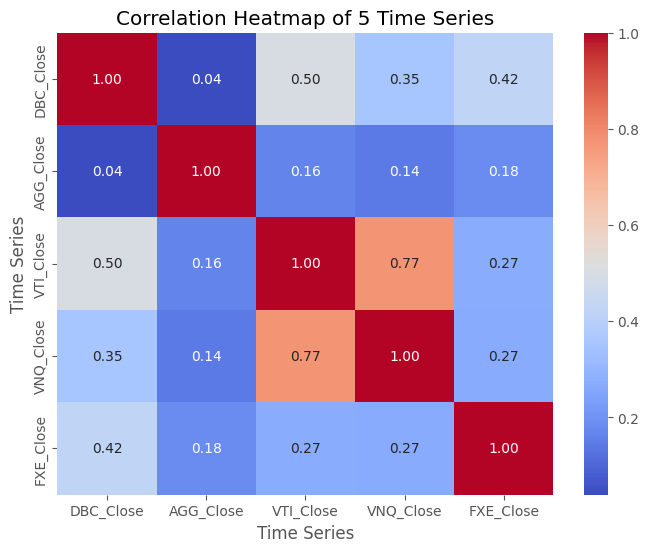

In [ ]:
# Calculate the correlation matrix - not very correlated. That's why multihead approach could help
target_cols = [col for col in history_train_clean.columns.values if 'Close' in col]

correlation_matrix = np.corrcoef(history_train_clean[target_cols], rowvar=False)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=target_cols, yticklabels=target_cols)
plt.title('Correlation Heatmap of 5 Time Series')
plt.xlabel('Time Series')
plt.ylabel('Time Series')
plt.show()

## Model Selection
The models implemented in this notebook are CNN-LSTM (including multi-head variations) architectures. This is a relatively simpler approach, however, there can be power in simplicity, hence it is a candidate worth considering.

### Helper Functions

In [ ]:
def plot_training_val_loss(metric1='loss', metric2='mae', plot_title='Returns prediction accuracy'):
  '''
  Plot training and validation loss
  '''
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  ax1.plot(train_fitted.history[metric1],'-o', label=f'Training {metric1}'.format())
  ax1.plot(train_fitted.history[f'val_{metric1}'.format()],'-o', label=f'Validation {metric1}'.format())
  ax1.set_title(f'Training and validation {metric1}'.format())
  ax1.set_ylabel(f'{metric1}'.format())
  ax1.set_xlabel('epoch')
  ax1.legend(loc='upper right')

  ax2.plot(train_fitted.history[metric2],'-o', label=f'Training {metric2}'.format())
  ax2.plot(train_fitted.history[f'val_{metric2}'.format()],'-o', label=f'Validation {metric2}'.format())
  ax2.set_title(f'Training and validation {metric2}'.format())
  ax2.set_ylabel(f'{metric2}'.format())
  ax2.set_xlabel('epoch')
  ax2.legend(loc='lower right')
  f.suptitle(plot_title)


def plot_returns(Y_true, Y_hat, time_axis=None):
  '''
  Plot predicted vs actual time series.
  If time axis is provided, set it as an axis rather than having integers as tick marks
  '''
  num_variables = len(TICKERS)
  fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, 10))

  # Plot predicted and actual values for each variable
  for i in range(num_variables):
      ax = axes[i]
      if time_axis is not None:
        ax.plot(time_axis, Y_true[:, i], label='Actual') #, color='blue'
        ax.plot(time_axis, Y_hat[:, i], label='Predicted') #, color='red'
      else:
        ax.plot(Y_true[:, i], label='Actual') #, color='blue'
        ax.plot(Y_hat[:, i], label='Predicted') #, color='red'
      ax.set_title(TICKERS[i])
      ax.legend()

  # Set common labels and layout
  plt.xlabel('Time')
  plt.tight_layout()
  plt.show()


def run_lime_explain(trained_model, idx=5):
  """
  LIME explain for specific model predictions (idx).
  This is used for probabilities, but our data is normalised, so we use this to explain.
  """
  for i in range(5):
    series = X_train[idx, :]
    explainer = RecurrentTabularExplainer(X_train, mode='regression', feature_names=pp.history_train_df.columns)
    exp = explainer.explain_instance(series, lambda x: trained_model(x).numpy().reshape(-1,5)[:,i])
    exp.as_pyplot_figure()
    plt.show()

### Markowitz Optimisation - Code

In [ ]:
def markowitz_portfolio(returns, cov_matrix, risk_free_rate, initial_weights=None,
                        diversification_penalty_coeff=0.1, deviation_penalty_coeff=0.1,
                        time_window=1):
    """
  Get portfolio weights based on Markowitz model across time. Starts from equal weights.
  Then use previous period weights as a reference point. Time window is the lenght
  of historical data to take into account. It needs to be greater or equal to 1
  so that there are at least 2 observations for covariance
  (at least one history + prediction)
    """
    num_assets = len(returns)
    if initial_weights is None:
        initial_weights = np.array([1 / num_assets] * num_assets)

    # Define constraints (sum of weights equals 1). Commented out set-up is for SLSQP optimizer
    #constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    constraints = LinearConstraint(np.repeat(1, num_assets), [1], [1])
    # Define bounds (weights between 0 and 1)
    #bounds = tuple((0, 1) for asset in range(num_assets))
    bounds = Bounds(np.repeat(0, num_assets), np.repeat(1, num_assets))

    # Define the objective function to minimize
    def negative_sharpe_ratio(weights):
        portfolio_return = np.dot(weights, returns)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
        diversification_penalty = np.sum(weights**2)
        deviation_penalty = np.sum((weights - initial_weights)**2)

        return (-sharpe_ratio +
                diversification_penalty_coeff * diversification_penalty +
                deviation_penalty_coeff * deviation_penalty)

    # Initialize optimization, need SLSQP or trust-constr given constraints.
    # Trust-constr is slower but results in a better convergence
    result = minimize(negative_sharpe_ratio, initial_weights, method='trust-constr', bounds=bounds,
                      constraints=constraints)

    # Try again with equal weights if optimization fails
    if not result.success:
      result = minimize(negative_sharpe_ratio, np.array([1 / num_assets] * num_assets),
                        method='SLSQP', bounds=bounds,
                        constraints=constraints)

    if not result.success:
        raise ValueError("Optimization failed: " + result.message)

    return result.x

def markowitz_weights(Y_realised, Y_predictions, risk_free_rates=0.02, time_window=1,
                      average_return_with_history=True, # take an average over prediction plus history in Markowitz
                      diversification_penalty_coeff=0.1, deviation_penalty_coeff=0.1):
    """
    Get portfolio weights based on Markowitz model across time. Starts from equal weights.
    Time window is the length of historical data to take into account. It needs to
    be greater or equal to 1 so that there are at least 2 observations for covariance
    (at least one history + prediction)
    """
    starting_weights = np.array([1.0 / len(TICKERS)] * len(TICKERS))
    all_weights = None
    for i in range(time_window, len(Y_realised)):
        ret_sequence = np.vstack([Y_realised[i - time_window : i], Y_predictions[i]])
        ret_sequence = np.exp(ret_sequence)-1 # Transform log returns to returns
        if average_return_with_history:
          mean_returns = np.mean(ret_sequence, axis=0)
        else:
          mean_returns = np.exp(Y_predictions[i])-1
        cov_matrix = np.cov(ret_sequence, rowvar=False)

        # Time-varying RF rate if provided, otherwise constant
        risk_free_rate = risk_free_rates[i] if len(risk_free_rates) > 1 else risk_free_rates

        weights = markowitz_portfolio(mean_returns, cov_matrix, risk_free_rate,
                                      initial_weights=starting_weights,
                                      diversification_penalty_coeff=diversification_penalty_coeff,
                                      deviation_penalty_coeff=deviation_penalty_coeff,
                                      time_window=time_window)
        all_weights = np.vstack([all_weights, weights]) if all_weights is not None else np.array([weights])

        # Use previous weights as a starting point for next optimization
        starting_weights = weights

    return all_weights


def plot_portfolio_weights(weights):
  """
  Plot portfolio weights. USes constants defined top of this notebook as labels
  """
  fig, ax = plt.subplots(figsize=(10, 6))
  bottom = np.zeros(weights.shape[0])

  for i in range(weights.shape[1]):
      ax.bar(range(weights.shape[0]), weights[:, i], label=TICKERS[i], bottom=bottom)
      bottom += weights[:, i]

  ax.set_xlabel('Time')
  ax.set_ylabel('Weights')
  ax.set_title('Portfolio Weights Over Time')
  ax.legend()
  ax.grid(True)
  plt.show()


def calculate_and_plot_returns(returns_data, weights1, weights2,
                               label1='Model1 Strategy', label2='Equal Weights',
                               plot_title='Test returns', time_axis=None,
                               return_df=False):
  """
  Calculate within period portfolio log returns and aggregated returns.
  Plot only, or plot and output a dataframe with results.
  Assumes we want our strategy and a benchmark strategy.
  Time axis is optional.
  """
  portfolio_log_returns = (weights1 * returns_data[MARKOWITZ_TIME_WINDOW:]).sum(axis=1)
  portfolio_log_returns2 = (weights2 * returns_data[MARKOWITZ_TIME_WINDOW:]).sum(axis=1)

  # Cumulative log returns
  cumulative_portfolio_log_return = np.cumsum(portfolio_log_returns)
  cumulative_portfolio_log_return2 = np.cumsum(portfolio_log_returns2)

  # Normal returns?
  cumulative_portfolio_return = np.exp(cumulative_portfolio_log_return) - 1
  cumulative_portfolio_return2 = np.exp(cumulative_portfolio_log_return2) - 1

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  ax1.plot(cumulative_portfolio_log_return, label=label1)
  ax1.plot(cumulative_portfolio_log_return2, label=label2)
  ax1.set_title('Cumulative log returns')
  ax1.set_ylabel('Cumulative log returns')
  ax1.set_xlabel('Time')
  ax1.legend(loc='upper right')

  ax2.plot(cumulative_portfolio_return, label=label1)
  ax2.plot(cumulative_portfolio_return2, label=label2)
  ax2.set_title('Cumulative returns')
  ax2.set_ylabel('Cumulative returns')
  ax2.set_xlabel('Time')
  ax2.legend(loc='upper right')
  f.suptitle(plot_title)

  output = {
      label1 + ' Log Return': portfolio_log_returns,
      label2 + ' Log Return': portfolio_log_returns2,
      label1 + ' Cumulative Log Return': cumulative_portfolio_log_return,
      label2 + ' Cumulative Log Return': cumulative_portfolio_log_return2,
      label1 + ' Cumulative Return': cumulative_portfolio_return,
      label2 + ' Cumulative Return': cumulative_portfolio_return2,
    }
  if time_axis is not None:
    output['Date'] = time_axis[MARKOWITZ_TIME_WINDOW:]

  if return_df:
    return pd.DataFrame(output)
  else:
    return

### Model 1 - Replicate Paper
 Out of a sample of 21 stocks, top k stocks with high predicted returns are shortlisted through CNN-LSTM model to further formulate an optimal portfolio through MV model.

This deep learning model configuration consists of 06 distinct layers: a one-dimensional (1D)-convolutional layer, a max pooling layer, a dropout layer, a flattened layer, an LSTM layer, and a dense layer, as shown in Figure 2. The traits and variables employed in the suggested hybrid deep learning model are presented in Table 3. A set of kernels [43] are included in the convolutional layer to create a tensor of feature mappings

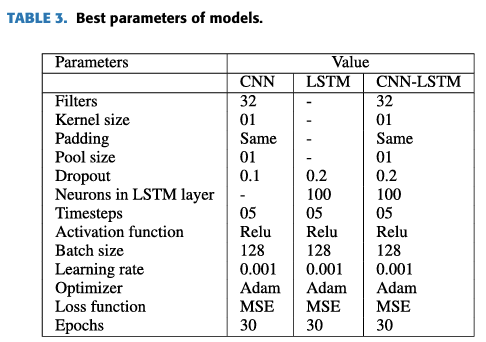

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 50, 32)            544       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 50, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 100)           53200     
                                                                 
 flatten_4 (Flatten)         (None, 5000)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 25005     
                                                      

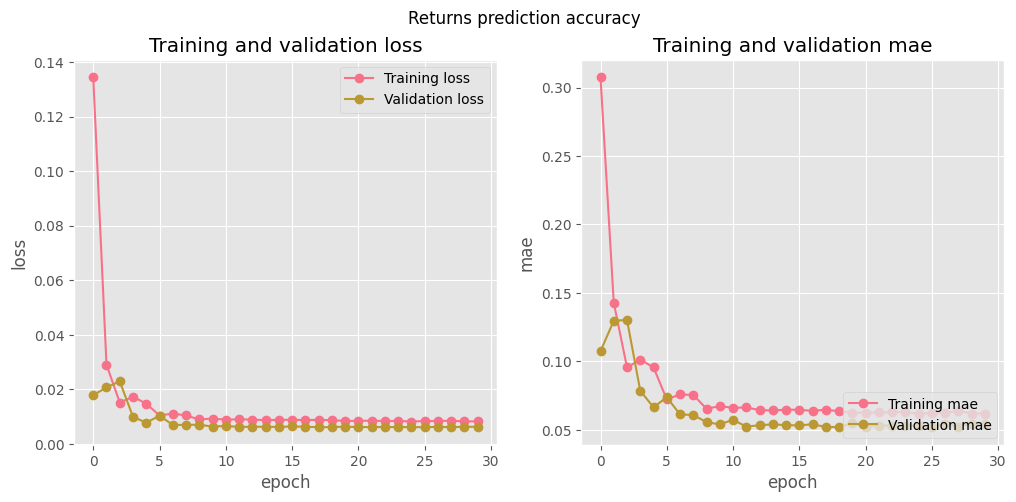

In [ ]:
# Replicate exact parameters from the paper, bear in mind the paper was predicting only equities though, and prices rather than returns.
model = Sequential()
model.add(layers.Conv1D(32, 1, padding='same', activation='relu', input_shape=(TIME_STEP, X_train.shape[2])))
model.add(layers.MaxPooling1D(pool_size=1))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(100, return_sequences=True))
model.add(layers.Flatten()) # Paper has Flatten before LSTM, model was complaining about that
model.add(layers.Dense(5))

model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(), metrics=['mae'])

train_fitted = model.fit(X_train, Y_train, epochs=30, batch_size=128, validation_split=0.2, verbose=0) #, callbacks=[callback]

plot_training_val_loss(metric1='loss', metric2='mae', plot_title='Returns prediction accuracy')

In [ ]:
# Evaluation of the model on test data
scores = model.evaluate(X_test, Y_test, verbose=0)
scores
print(f"MSE: {scores[0]}" )

# Predict train
train_predictions = model.predict(X_train)

train_predictions_scaled = y_scaler_train.inverse_transform(train_predictions)
Y_train_scaled = y_scaler_train.inverse_transform(Y_train)

# Predict test
test_predictions = model.predict(X_test)

test_predictions_scaled = y_scaler_test.inverse_transform(test_predictions)
Y_test_scaled = y_scaler_test.inverse_transform(Y_test)

MSE: 0.04899981617927551
4/4 [==============================] - 0s 3ms/step


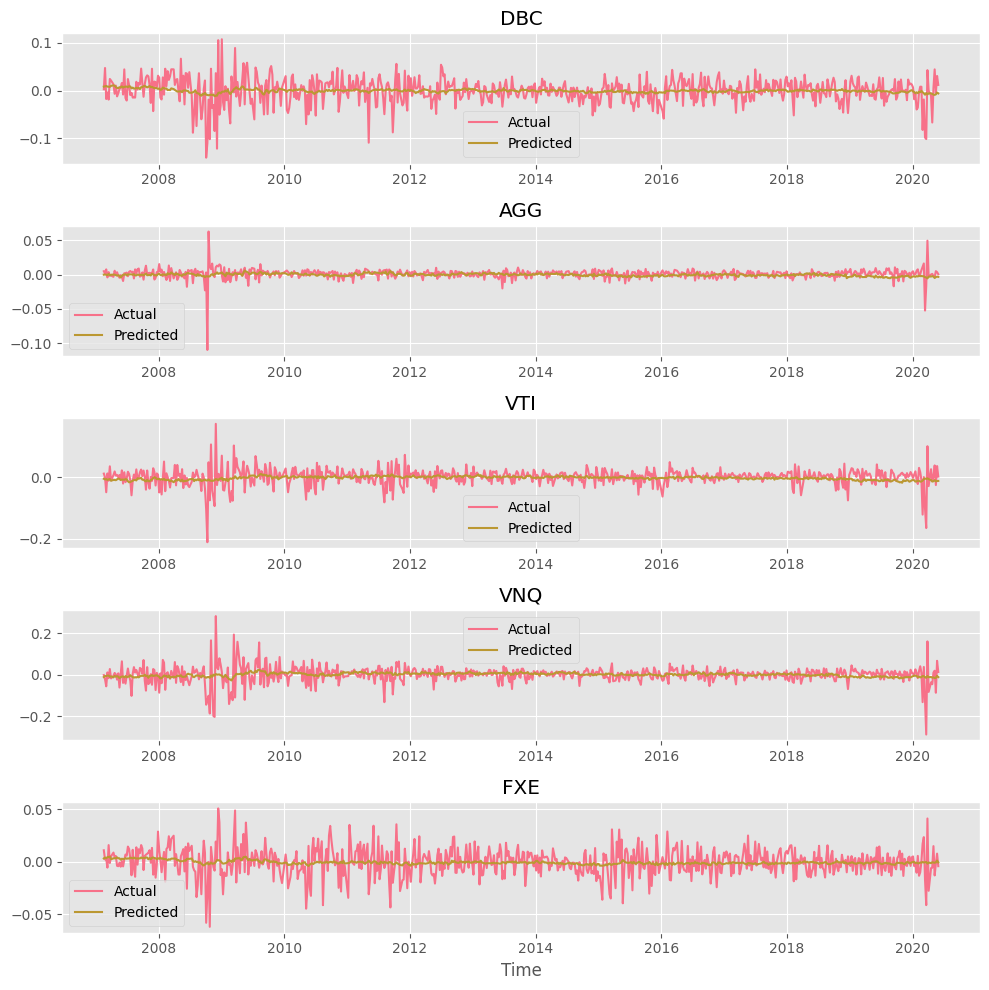

In [ ]:
plot_returns(Y_train_scaled, train_predictions_scaled, time_axis=train_date_index)

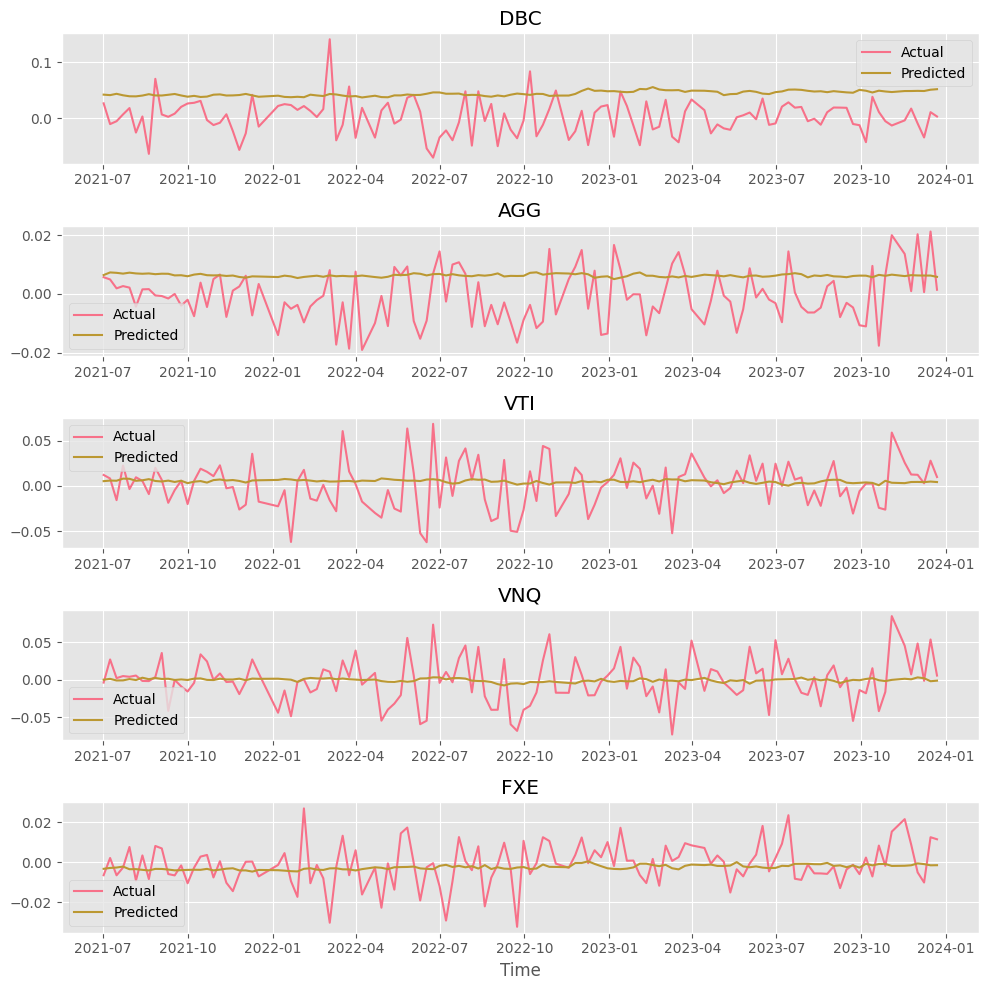

In [ ]:
plot_returns(Y_test_scaled, test_predictions_scaled, time_axis=test_date_index)

LIME provides further context on why the model outputs a straight line - the key influence is coming from FedFunds, which indicates a spurious relationship detected.

Explanation as of date: 2008-09-26 00:00:00


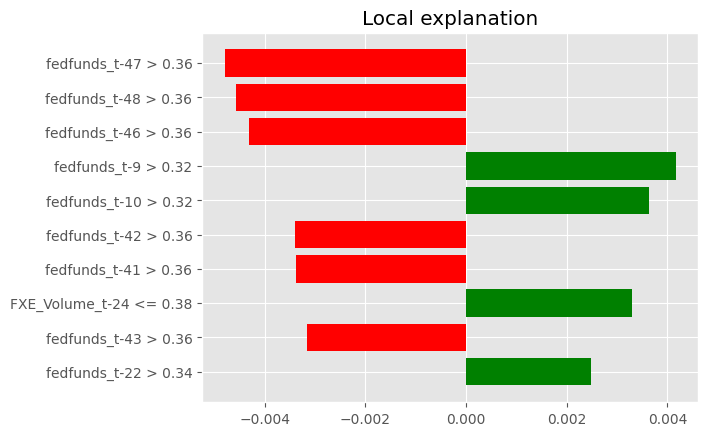

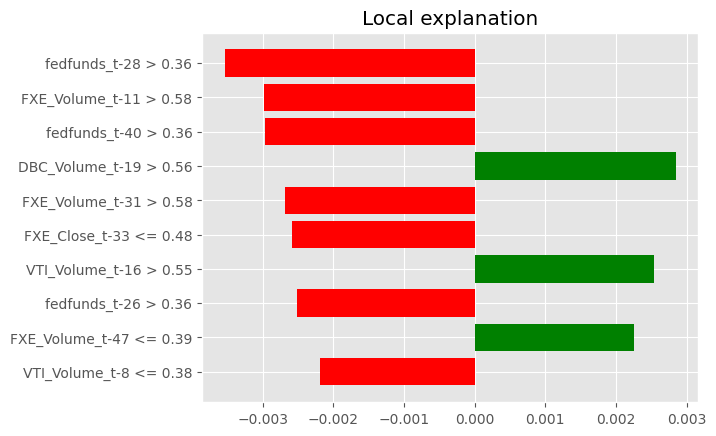

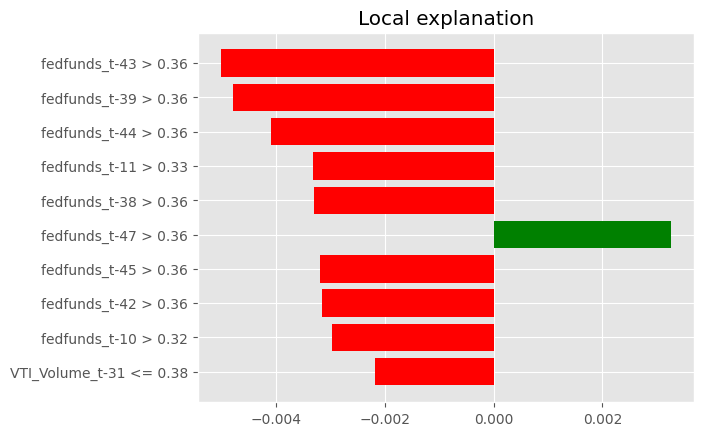

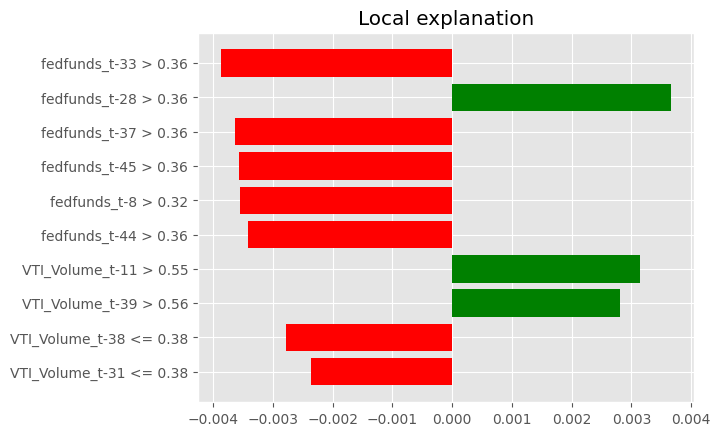

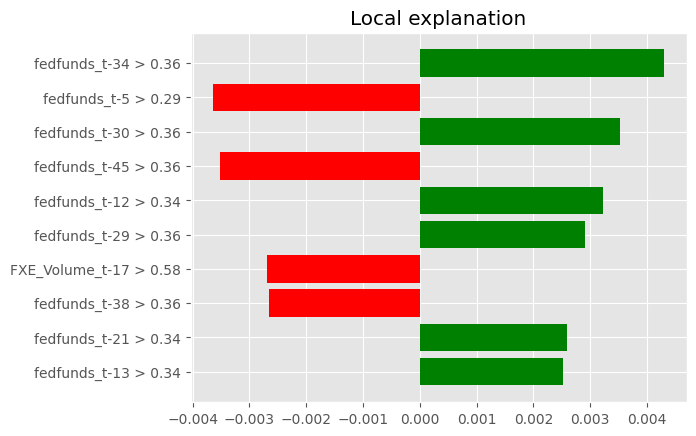

In [ ]:
idx = 81 # Date right after Lehman Brothers bankrupcy, we want to see what was used to explain
print(f'Explanation as of date: {train_date_index[idx]}')
run_lime_explain(model, idx=idx)

We can see that the model discussed in the paper learns approximately the data average, no curvature to the prediction shape. The following steps will discuss further enhancements made to this simple model - especially the aim is to start picking up the curvature.

In [ ]:
model = Sequential()
model.add(layers.Conv1D(32, 1, padding='same', activation='elu', input_shape=(TIME_STEP, X_train.shape[2])))
model.add(layers.MaxPooling1D(pool_size=1))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(100, return_sequences=True))
model.add(layers.Flatten()) # Paper has Flatten before LSTM, model was complaining about that
model.add(layers.Dense(5))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 50, 32)            544       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 50, 32)            0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 50, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50, 100)           53200     
                                                                 
 flatten_5 (Flatten)         (None, 5000)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 25005     
                                                      

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.MeanSquaredError(), metrics=['mae'])

In [ ]:
# Fit
#callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, start_from_epoch=100)
train_fitted = model.fit(X_train, Y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=0) #, callbacks=[callback]

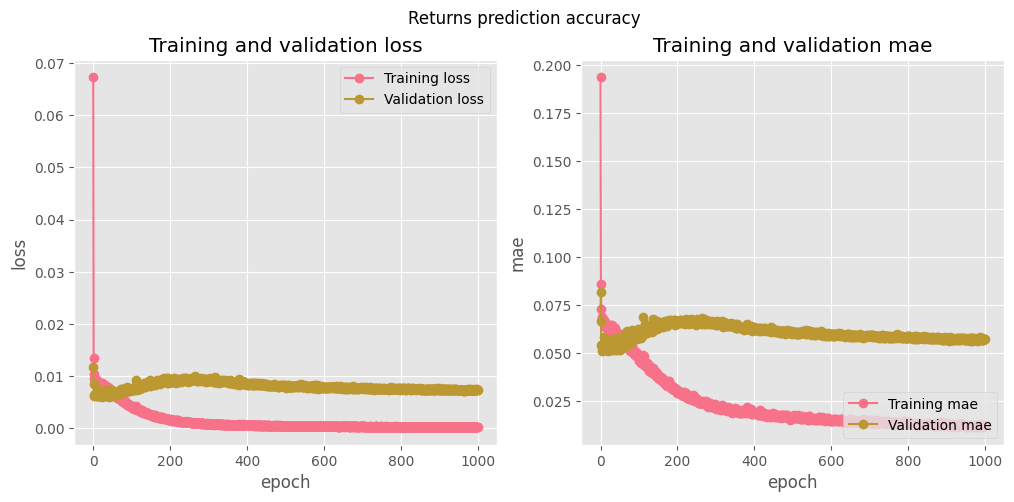

In [ ]:
plot_training_val_loss(metric1='loss', metric2='mae', plot_title='Returns prediction accuracy')

In [ ]:
keras.saving.save_model(model, CACHE_PATH + '/st456_portfolio_project_model_paper1', overwrite=True)
model = keras.saving.load_model(CACHE_PATH + '/st456_portfolio_project_model_paper1')

In [ ]:
# Evaluation of the model on test data
scores = model.evaluate(X_test, Y_test, verbose=0)
scores
print(f"MSE: {scores[0]}" )

# Predict train
train_predictions = model.predict(X_train)

train_predictions_scaled = y_scaler_train.inverse_transform(train_predictions)
Y_train_scaled = y_scaler_train.inverse_transform(Y_train)

# Predict test
test_predictions = model.predict(X_test)

test_predictions_scaled = y_scaler_test.inverse_transform(test_predictions)
Y_test_scaled = y_scaler_test.inverse_transform(Y_test)

MSE: 0.05742446333169937
4/4 [==============================] - 0s 3ms/step


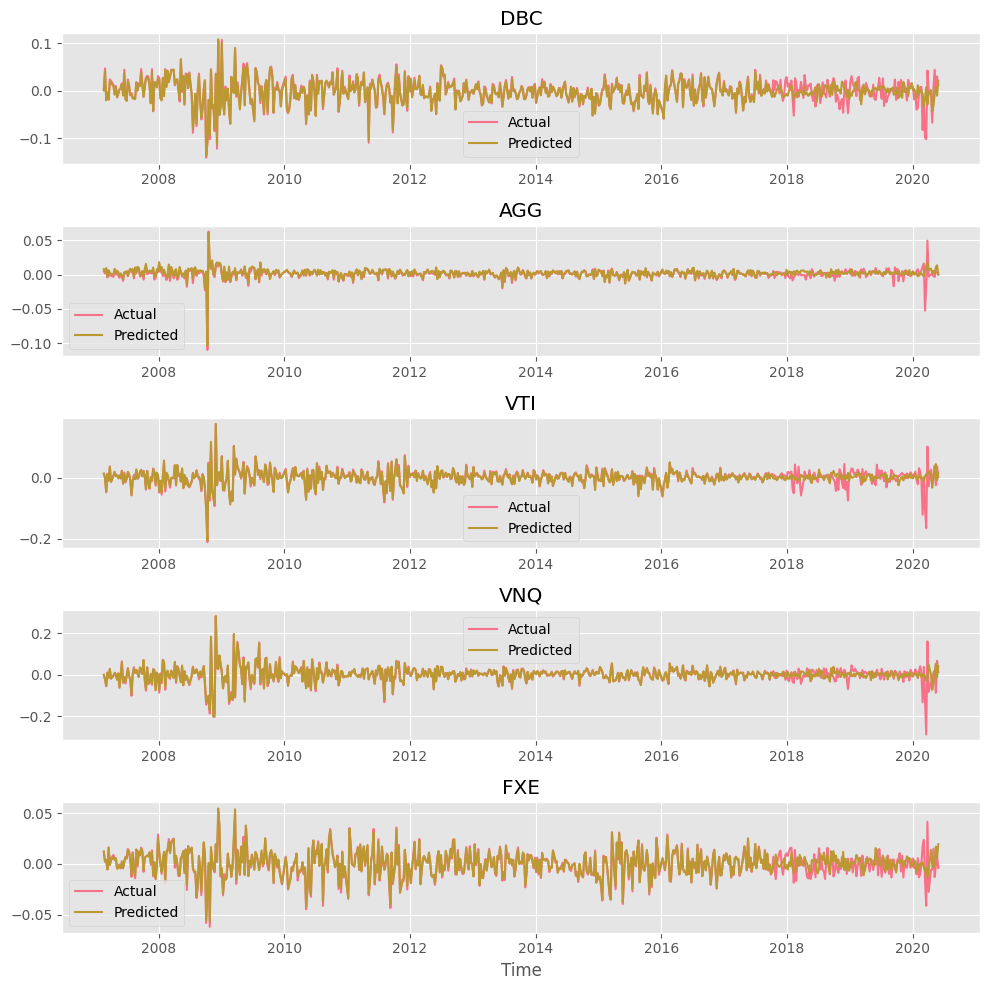

In [ ]:
plot_returns(Y_train_scaled, train_predictions_scaled, time_axis=train_date_index)

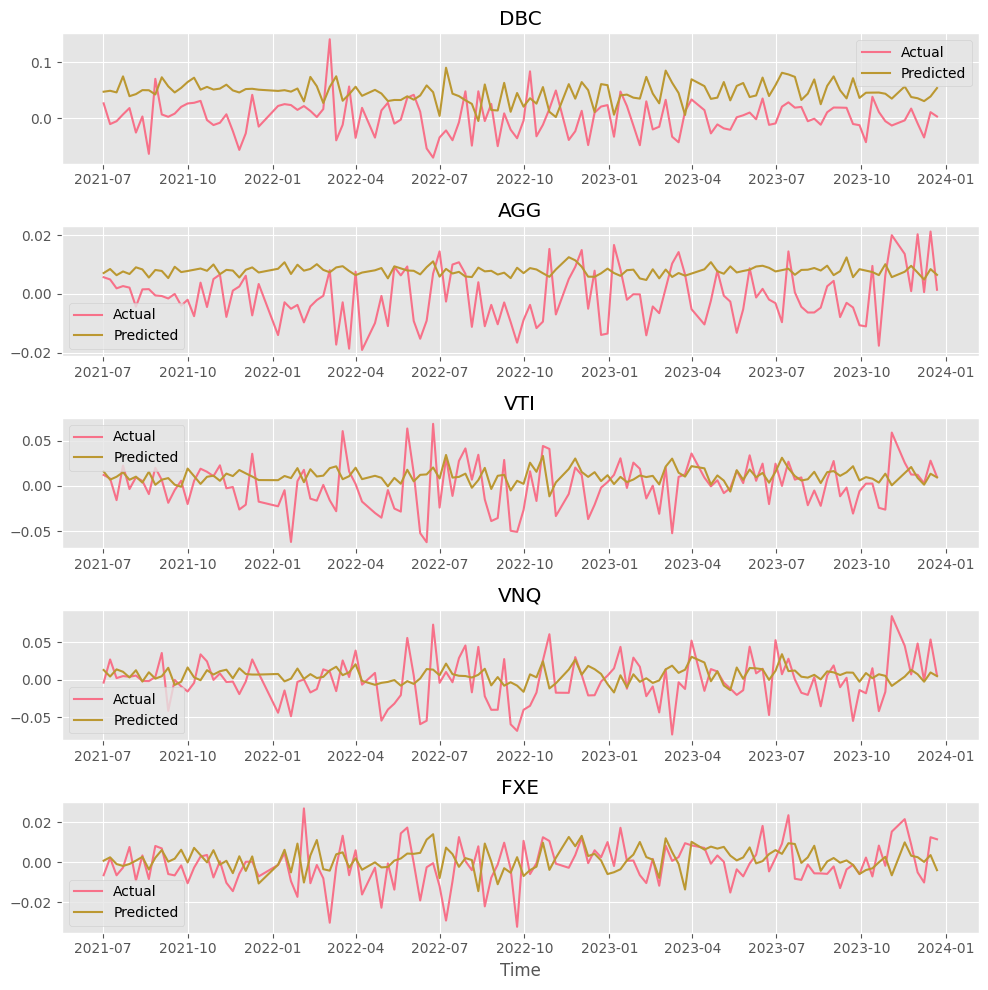

In [ ]:
plot_returns(Y_test_scaled, test_predictions_scaled, time_axis=test_date_index)

Especially the longer training time leads to model starting to learn the data curvature over time rather than just a simple average.

The model infers its prediction from Volume. Still kind of questionable theoretically.

Explanation as of date: 2008-09-26 00:00:00


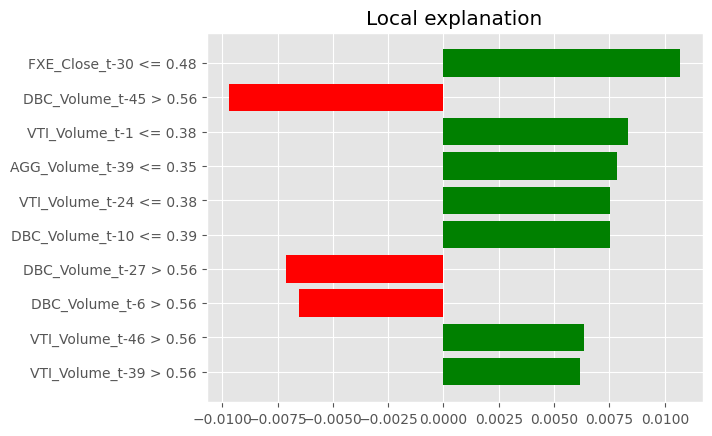

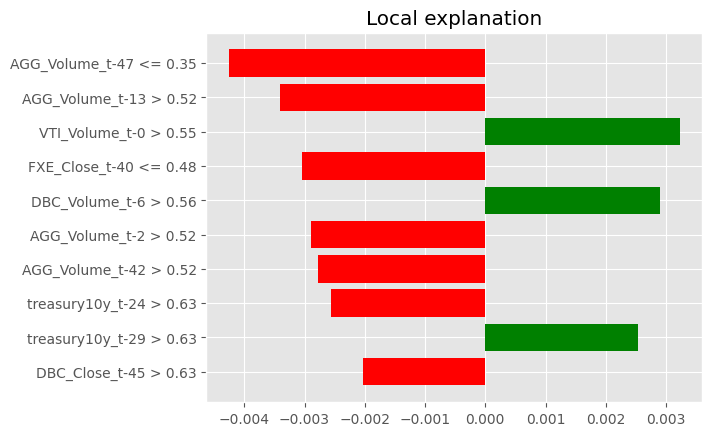

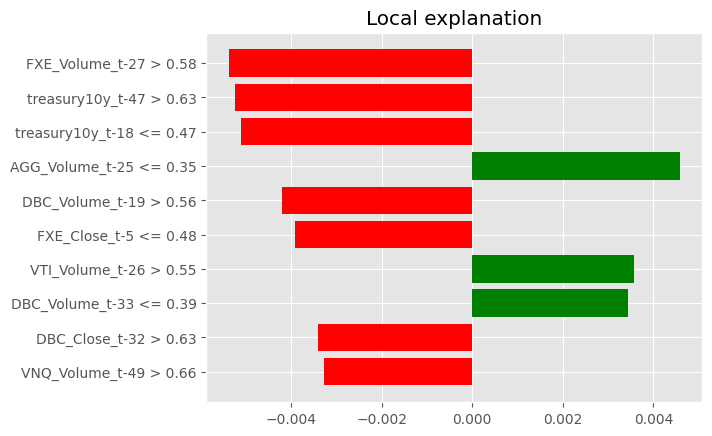

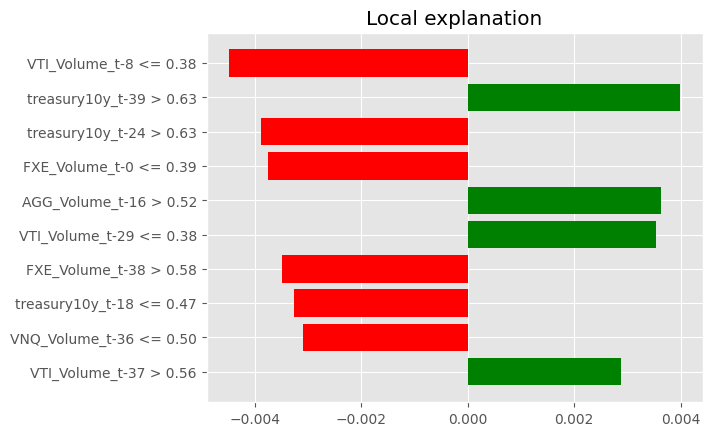

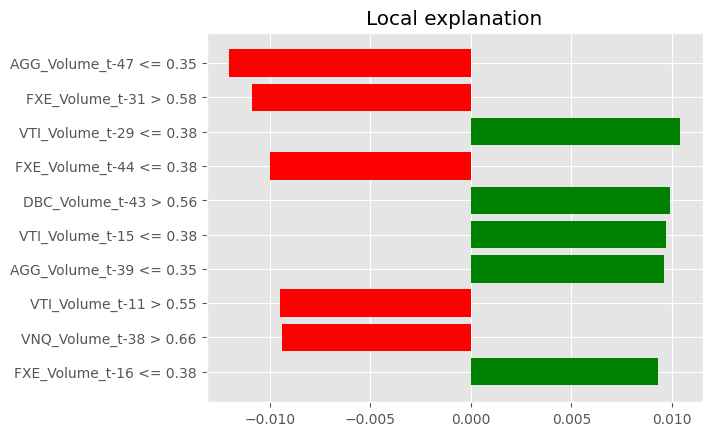

In [ ]:
idx = 81
print(f'Explanation as of date: {train_date_index[idx]}')
run_lime_explain(model, idx=idx)

#### Markowitz Portfolio

In [ ]:
# time window to consider in cov matrix, and to calculate an average for E(R)
# if average_return_with_history is set to true
MARKOWITZ_TIME_WINDOW = 5

# Create equal weights portfolio to serve as a performance benchmark (a naive model)
equal_weights_test = np.array([np.repeat(1/len(TICKERS), len(TICKERS)) for _ in
                               range(Y_test_scaled[MARKOWITZ_TIME_WINDOW:].shape[0])])

equal_weights_train = np.array([np.repeat(1/len(TICKERS), len(TICKERS)) for _ in
                                range(Y_train_scaled[MARKOWITZ_TIME_WINDOW:].shape[0])])

# Divide by 52 to make the annual RF rate weekly
risk_free_train = pp.risk_free_train['fedfunds']/(100*52)
risk_free_test = pp.risk_free_test['fedfunds']/(100*52)

In [ ]:
# Silence - running many optimizations and some of them show this warning
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

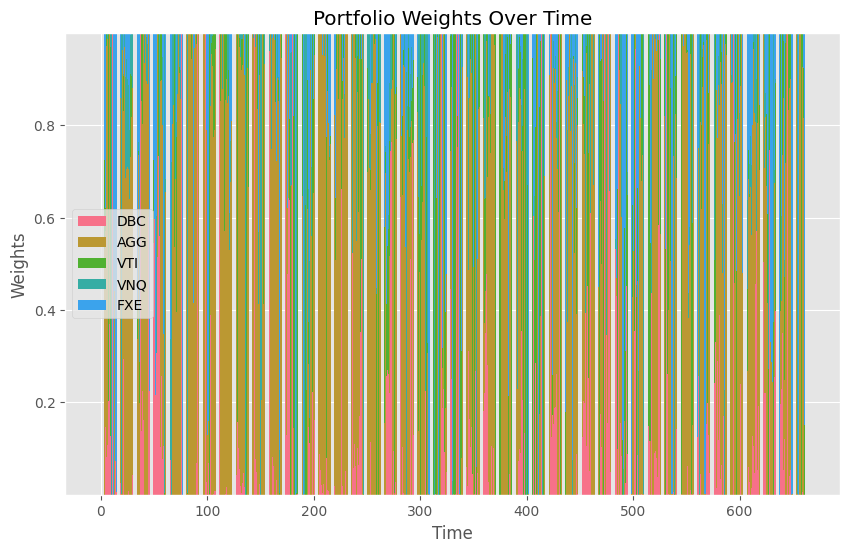

In [ ]:
train_weights = markowitz_weights(Y_train_scaled, train_predictions_scaled,
                                  average_return_with_history=False,
                                  risk_free_rates=risk_free_train,
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  )
plot_portfolio_weights(train_weights)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

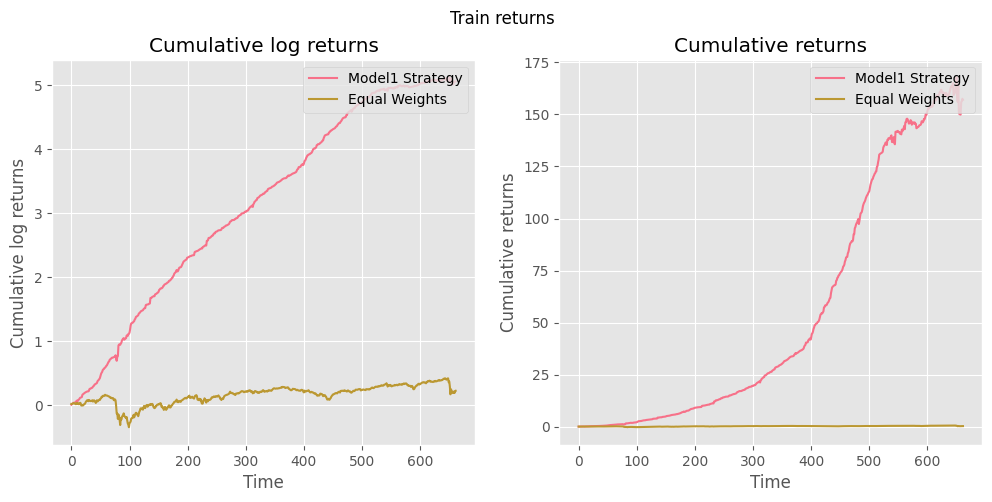

In [ ]:
train_ret_df = calculate_and_plot_returns(Y_train_scaled, train_weights, equal_weights_train,
                                          plot_title='Train returns',
                                          time_axis=train_date_index, return_df=True)
train_ret_df.to_csv('Model1_Train.csv')
files.download('Model1_Train.csv')

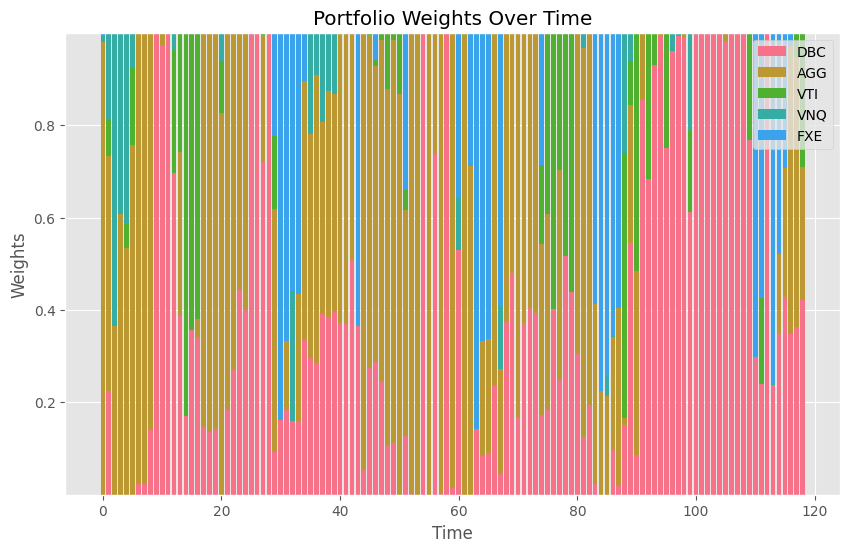

In [ ]:
MARKOWITZ_TIME_WINDOW = 5
test_weights = markowitz_weights(Y_test_scaled, test_predictions_scaled,
                                 average_return_with_history=False,
                                  risk_free_rates=risk_free_test, # RF rate is annual, make it weekly
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  )
plot_portfolio_weights(test_weights)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

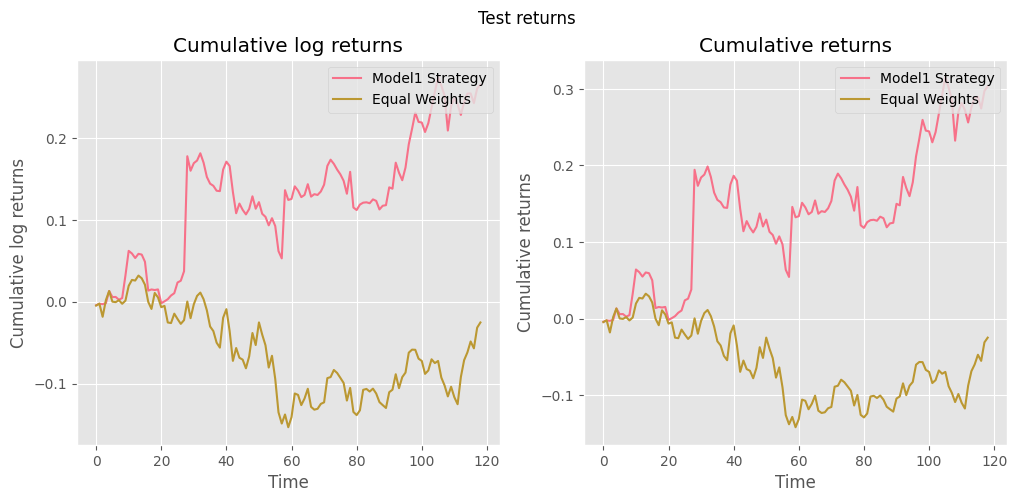

In [ ]:
test_ret_df = calculate_and_plot_returns(Y_test_scaled, test_weights, equal_weights_test,
                                          plot_title='Test returns',
                                          time_axis=test_date_index, return_df=True)
test_ret_df.to_csv('Model1_Test.csv')
files.download('Model1_Test.csv')

We are doing better than the naive model. However, the next step is to try and tune the model further to reduce the prediction error and increase the strategy returns.

## Model Tuning
In this step, we consider:
- **Multi-head approach**: given the ETFs historically do not show high correlation across all asset classes, we will try adding more heads that will be then concatenated into one layer. The model may be then able to pick up some signals idiosyncratic to each asset class.
- **Numer of filters in each head**: Iterating over the optimal number of Conv1D filters in each head
- **Kernel size in each head**: We try varying sizes of the kernel in each head.
- **Head activation**: We test out the linear activation, elu, and relu.
-**LSTM Units**: A range of LSTM units to try.
-**L1 penalty in each head**: Prevent overfitting.
-**L2 penalty in the final Dense layer**: Prevent overfitting.

In [ ]:
def build_model(hp):
  input_shape = (TIME_STEP, X_train.shape[2])
  num_heads = hp.Int("num_layers", 1, len(TICKERS))
  head_filters = hp.Int("filters_head", min_value=10, max_value=30, step=10)
  head_kernel_size = hp.Int("kernel_size_head", min_value=1, max_value=3, step=1)
  head_activation = hp.Choice("head_activation", values=['linear', 'elu', 'relu'])
  head_pool_size = hp.Int("pool_size_head", min_value=1, max_value=3, step=1)

  filters_concat = filters=hp.Int("filters_concat", min_value=10, max_value=50, step=20)
  kernel_concat = hp.Int("kernel_concat", min_value=1, max_value=10, step=2)

  lstm_units = hp.Int("units", min_value=50, max_value=150, step=50)
  # add_dropout = hp.Boolean("dropout")

  l2_dense = hp.Choice("l2_dense", [0.0, 0.001, 0.01])
  l1_head = hp.Choice("l1_head", [0.0, 0.001, 0.01])

 # adam_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  #optimizer = hp.Choice("optimizer", ["adam", "SGD"])

  model = define_model(input_shape, num_heads, head_filters, head_activation, head_kernel_size, head_pool_size,
                       filters_concat, kernel_concat, lstm_units, # adam_learning_rate, #optimizer,
                       l1_head, l2_dense
                       )
  return model


def define_model(input_shape, num_heads, head_filters, head_activation, head_kernel_size, head_pool_size,
                 filters_concat, kernel_concat, lstm_units, # adam_learning_rate, #optimizer,
                 l1_head, l2_dense
                 ):
  input_layer = keras.layers.Input(shape=input_shape)

  head_list = []
  for i in range(num_heads):
    conv_layer_head = layers.Conv1D(
      filters=head_filters,
      kernel_size=head_kernel_size,
      padding='same',
      activation=head_activation,
      kernel_regularizer=keras.regularizers.L1(l1=l1_head)
    )(input_layer)

    conv_layer_head = layers.MaxPooling1D(pool_size=head_pool_size)(conv_layer_head)
    head_list.append(conv_layer_head)

  concat_cnn = keras.layers.Concatenate(axis=1)(head_list)
  concat_cnn = layers.Conv1D(filters_concat, kernel_size=kernel_concat)(concat_cnn)
  lstm = layers.LSTM(units=lstm_units, return_sequences=True)(concat_cnn)

  lstm = layers.Dropout(0.2)(lstm)
  lstm = layers.Flatten()(lstm)
  dense = layers.Dense(5, kernel_regularizer=keras.regularizers.L2(l2=l2_dense))(lstm)

  model_multihead = keras.Model(inputs=input_layer, outputs=dense)

  model_multihead.compile(optimizer='adam', # keras.optimizers.Adam(learning_rate=adam_learning_rate), # optimizer,
                loss=keras.losses.MeanSquaredError(), metrics=['mae', 'mse'])
  return model_multihead

In [ ]:
build_model(keras_tuner.HyperParameters())

### Random Search Optimization

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="mae",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory=CACHE_PATH,
    project_name="st456_portfolio_project",
)

tuner.search(X_train, Y_train, epochs=5, validation_split=0.2)

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

### Bayesian Optimization

In [ ]:
tuner_bo = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=1,
    overwrite=True,
    directory=CACHE_PATH,
    project_name="st456_portfolio_project",
)

tuner_bo.search(X_train, Y_train, epochs=10, validation_split=0.2)

Trial 30 Complete [00h 00m 11s]
mae: 0.06883712112903595

Best mae So Far: 0.0627957135438919
Total elapsed time: 00h 04m 38s


In [ ]:
# Get the top 2 models.
models = tuner_bo.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 16)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 50, 30)               1470      ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 50, 30)               1470      ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 50, 30)               0         ['conv1d[0][0]']              
 D)                                                                                           

### Hyperband Tuning

In [ ]:
tuner_hb = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    overwrite=True,
    directory=CACHE_PATH,
    project_name="st456_portfolio_project_hyperbandv2_weekly",
)

callback = keras.callbacks.EarlyStopping(monitor="val_mae", patience=3, start_from_epoch=2)
tuner_hb.search(X_train, Y_train, epochs=10, validation_split=0.2, callbacks=[callback])

Trial 254 Complete [00h 00m 09s]
val_loss: 0.9487631916999817

Best val_loss So Far: 0.006140149664133787
Total elapsed time: 00h 28m 32s


In [ ]:
# Get the top 2 models.
models = tuner_hb.get_best_models(num_models=5)
best_model = models[0]
best_model.summary()

best_model2 = models[1]
best_model3 = models[2]
best_model4 = models[3]
best_model5 = models[4]

keras.saving.save_model(best_model, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_v3', overwrite=True)
keras.saving.save_model(best_model2, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_2ndbest_v3', overwrite=True)
keras.saving.save_model(best_model3, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_3rdbest_v3', overwrite=True)
keras.saving.save_model(best_model4, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_4thbest_v3', overwrite=True)
keras.saving.save_model(best_model5, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_5thbest_v3', overwrite=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 16)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 50, 20)               340       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 50, 20)               340       ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 50, 20)               340       ['input_1[0][0]']             
                                                                                              

 max_pooling1d (MaxPooling1  (None, 50, 20)               0         ['conv1d[0][0]']              


 D)                                                                                               


 max_pooling1d_1 (MaxPoolin  (None, 50, 20)               0         ['conv1d_1[0][0]']            


 g1D)                                                                                             
                                                                                                  


 max_pooling1d_2 (MaxPoolin  (None, 50, 20)               0         ['conv1d_2[0][0]']            
 g1D)                                                                                             


 max_pooling1d_3 (MaxPoolin  (None, 50, 20)               0         ['conv1d_3[0][0]']            


 g1D)                                                                                             


                                                                                                  
 concatenate (Concatenate)   (None, 200, 20)              0         ['max_pooling1d[0][0]',       


                                                                     'max_pooling1d_1[0][0]',     


                                                                     'max_pooling1d_2[0][0]',     
                                                                     'max_pooling1d_3[0][0]']     


 conv1d_4 (Conv1D)           (None, 200, 10)              210       ['concatenate[0][0]']         


 lstm (LSTM)                 (None, 200, 100)             44400     ['conv1d_4[0][0]']            


 dropout (Dropout)           (None, 200, 100)             0         ['lstm[0][0]']                


 flatten (Flatten)           (None, 20000)                0         ['dropout[0][0]']             


 dense (Dense)               (None, 5)                    100005    ['flatten[0][0]']             


Total params: 145975 (570.21 KB)


Trainable params: 145975 (570.21 KB)


Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [ ]:
#best_model = keras.saving.load_model(CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_2ndbest_v2')
best_model = keras.saving.load_model(CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_v3_retrained')
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 16)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 50, 20)               340       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 50, 20)               340       ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 50, 20)               340       ['input_1[0][0]']             
                                                                                              

In [ ]:
best_hps = tuner_hb.get_best_hyperparameters(num_trials=5)
for i in range(0,5):
  print(best_hps[i].values)

{'num_layers': 4, 'filters_head': 20, 'kernel_size_head': 1, 'head_activation': 'elu', 'pool_size_head': 1, 'filters_concat': 10, 'kernel_concat': 1, 'units': 100, 'l2_dense': 0.0, 'l1_head': 0.0, 'tuner/epochs': 34, 'tuner/initial_epoch': 12, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0189'}
{'num_layers': 2, 'filters_head': 10, 'kernel_size_head': 1, 'head_activation': 'linear', 'pool_size_head': 1, 'filters_concat': 50, 'kernel_concat': 9, 'units': 150, 'l2_dense': 0.0, 'l1_head': 0.0, 'tuner/epochs': 12, 'tuner/initial_epoch': 4, 'tuner/bracket': 4, 'tuner/round': 2, 'tuner/trial_id': '0106'}
{'num_layers': 2, 'filters_head': 10, 'kernel_size_head': 2, 'head_activation': 'relu', 'pool_size_head': 1, 'filters_concat': 10, 'kernel_concat': 3, 'units': 150, 'l2_dense': 0.0, 'l1_head': 0.0, 'tuner/epochs': 34, 'tuner/initial_epoch': 12, 'tuner/bracket': 3, 'tuner/round': 2, 'tuner/trial_id': '0190'}
{'num_layers': 2, 'filters_head': 10, 'kernel_size_head': 1, 'head_activa

In [ ]:
# callback = keras.callbacks.EarlyStopping(monitor="val_mae", patience=5, start_from_epoch=20)
train_fitted = best_model.fit(x=X_train, y=Y_train, epochs=1000, validation_split=0.2) # callbacks=[callback],

Epoch 1/1000
17/17 [==============================] - 4s 50ms/step - loss: 0.0549 - mae: 0.1806 - mse: 0.0549 - val_loss: 0.0105 - val_mae: 0.0818 - val_mse: 0.0105
Epoch 2/1000
17/17 [==============================] - 0s 15ms/step - loss: 0.0125 - mae: 0.0807 - mse: 0.0125 - val_loss: 0.0065 - val_mae: 0.0533 - val_mse: 0.0065
Epoch 3/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.0091 - mae: 0.0662 - mse: 0.0091 - val_loss: 0.0064 - val_mae: 0.0520 - val_mse: 0.0064
Epoch 4/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.0082 - mae: 0.0619 - mse: 0.0082 - val_loss: 0.0065 - val_mae: 0.0519 - val_mse: 0.0065
Epoch 5/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.0085 - mae: 0.0625 - mse: 0.0085 - val_loss: 0.0069 - val_mae: 0.0547 - val_mse: 0.0069
Epoch 6/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.0080 - mae: 0.0619 - mse: 0.0080 - val_loss: 0.0069 - val_mae: 0.0572 - val_mse: 0.0069
Epoch 7/10

In [ ]:
# best so far
keras.saving.save_model(best_model, CACHE_PATH + '/st456_portfolio_project_hyperband_fullmodel_weekly_v3_retrained', overwrite=True)

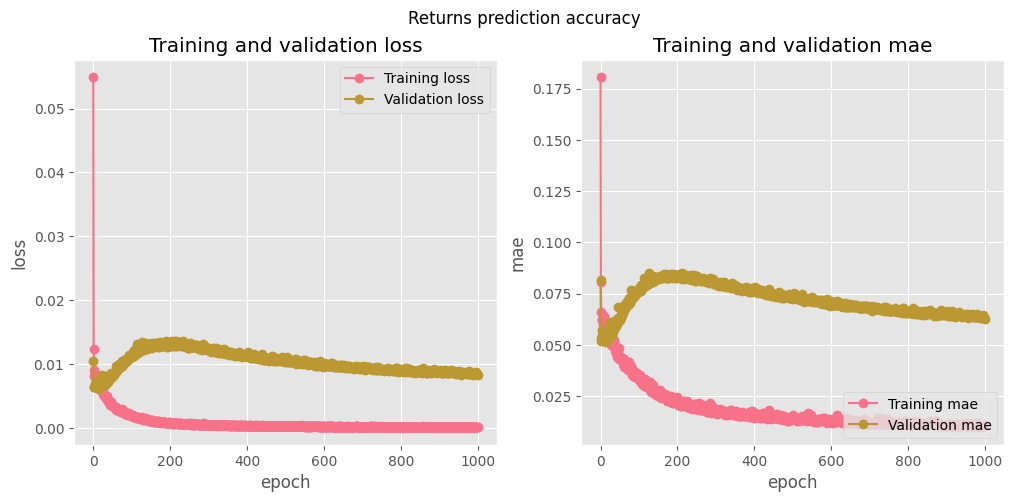

In [ ]:
plot_training_val_loss(metric1='loss', metric2='mae', plot_title='Returns prediction accuracy')

In [ ]:
# Evaluation of the model on test data
scores = best_model.evaluate(X_test, Y_test, verbose=0)
scores
print(f"Test loss: {scores[0]}" )

# Train predictions
train_predictions_bestmodel = best_model.predict(X_train)

train_predictions_bestmodel_scaled = y_scaler_train.inverse_transform(train_predictions_bestmodel)
Y_train_scaled = y_scaler_train.inverse_transform(Y_train)

# Test Predictions
test_predictions_bestmodel = best_model.predict(X_test)

test_predictions_bestmodel_scaled = y_scaler_test.inverse_transform(test_predictions_bestmodel)
Y_test_scaled = y_scaler_test.inverse_transform(Y_test)

Test loss: 0.06888154149055481
4/4 [==============================] - 0s 5ms/step


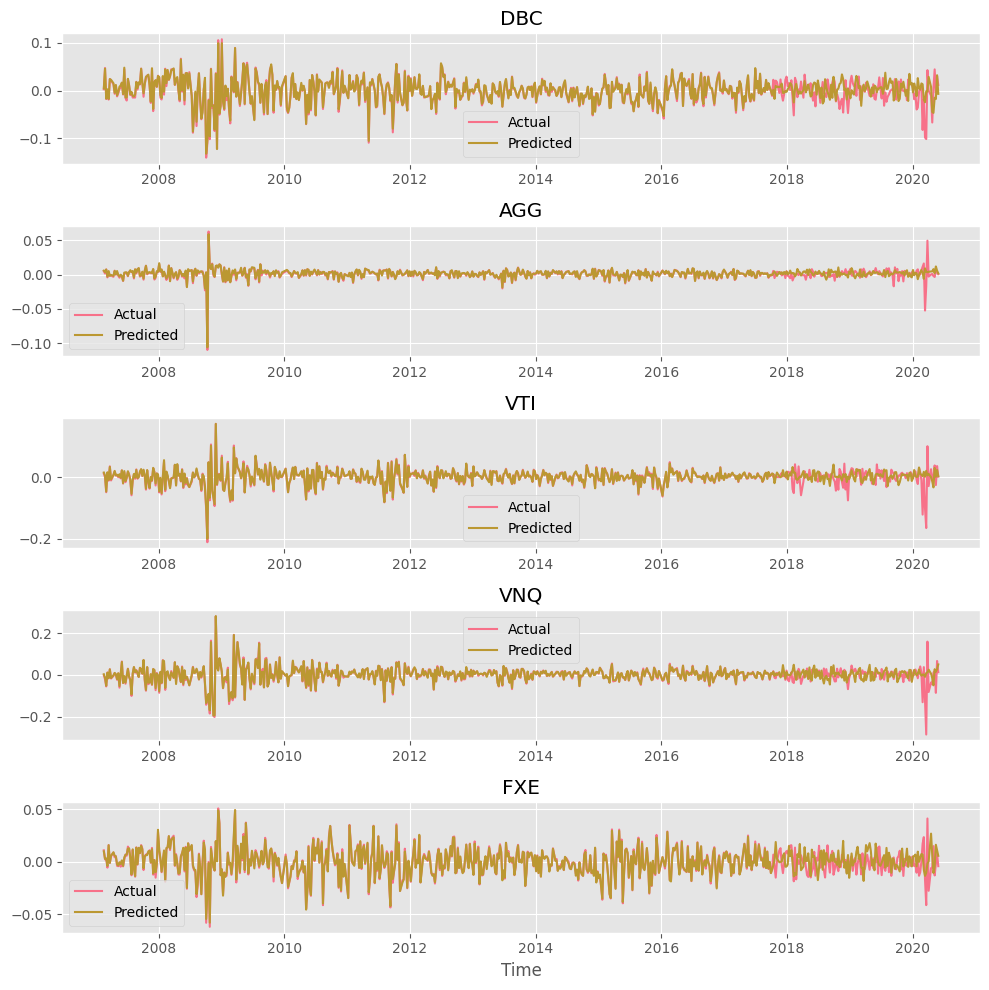

In [ ]:
plot_returns(Y_train_scaled, train_predictions_bestmodel_scaled, time_axis=train_date_index)

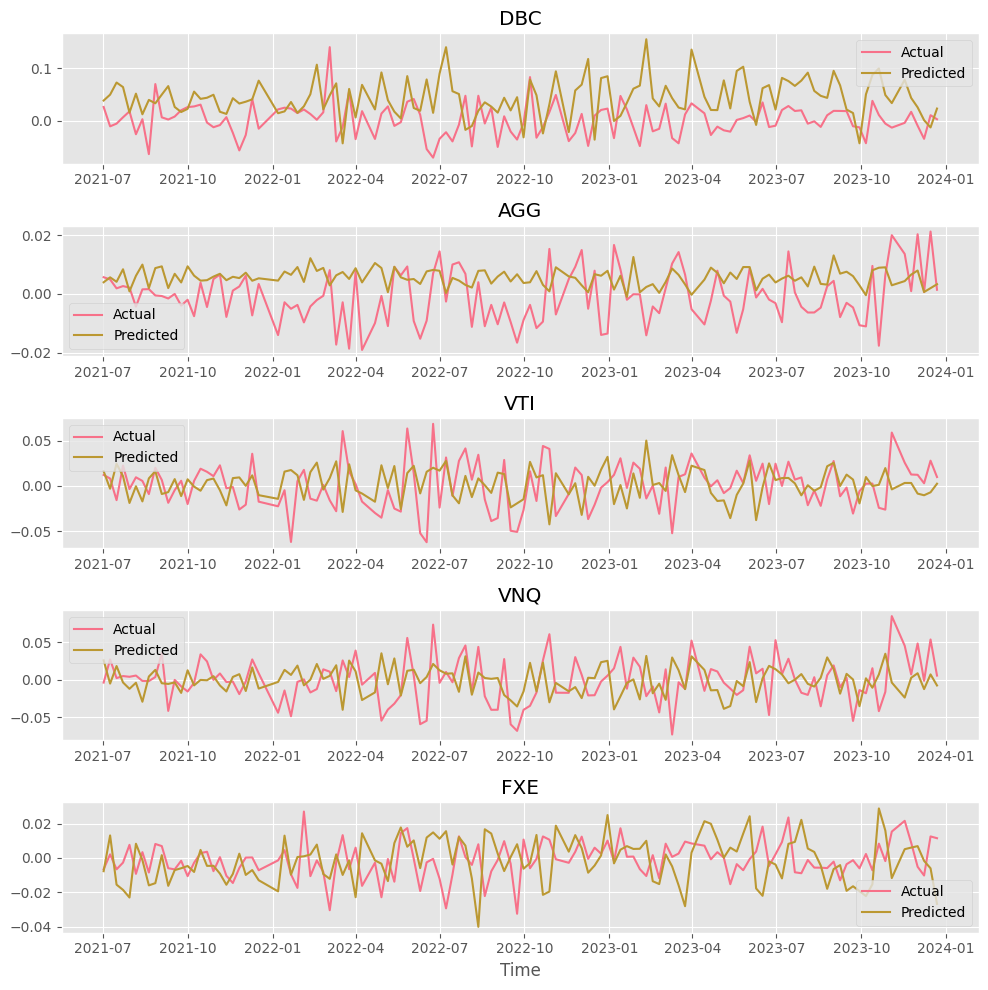

In [ ]:
plot_returns(Y_test_scaled, test_predictions_bestmodel_scaled, time_axis=test_date_index)

Tuned model seems to rely on more intuitive explanatory variables

Explanation as of date: 2008-09-26 00:00:00


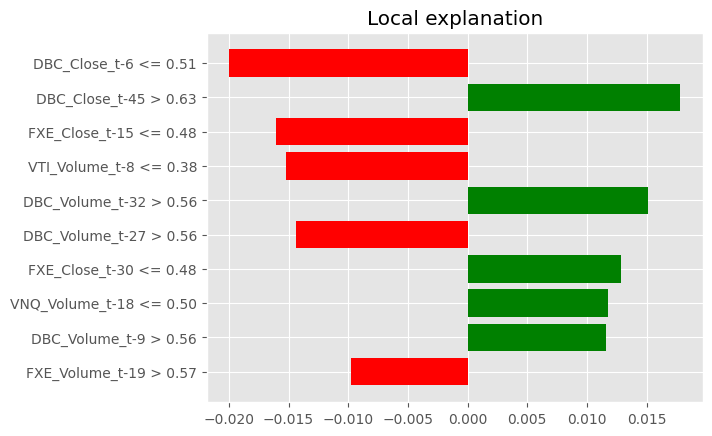

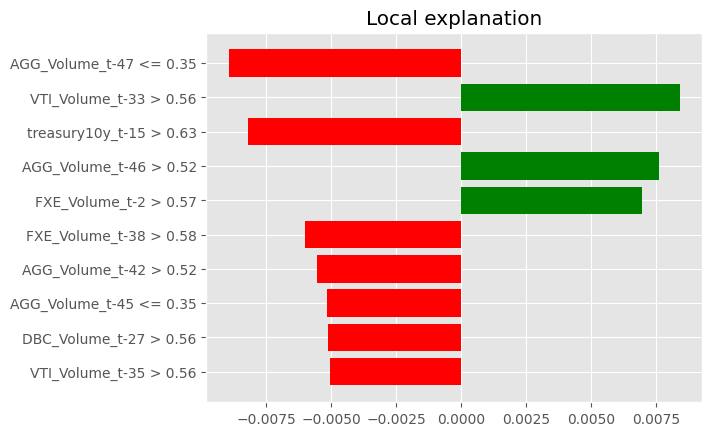

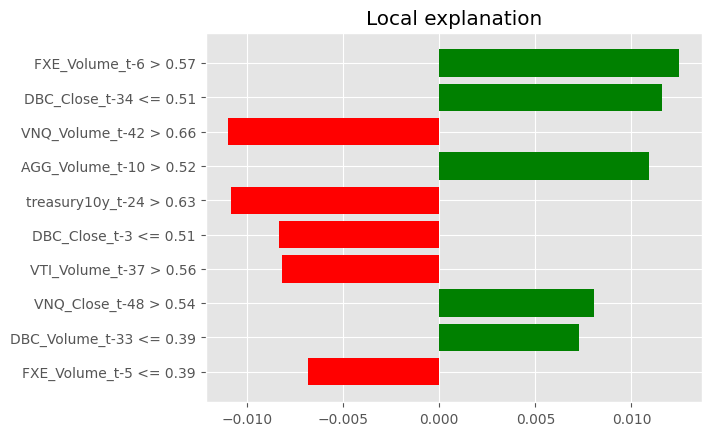

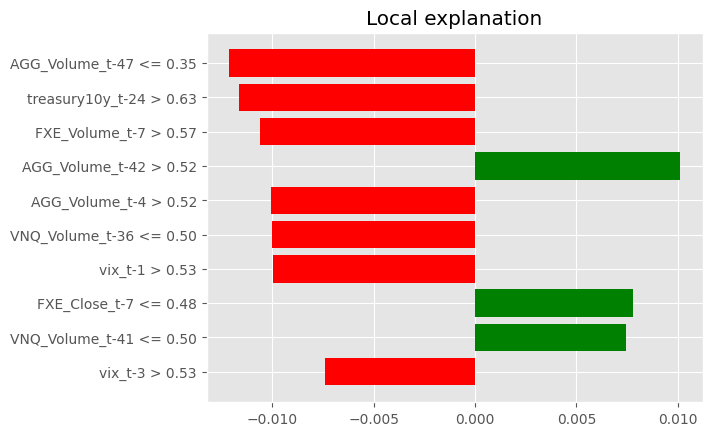

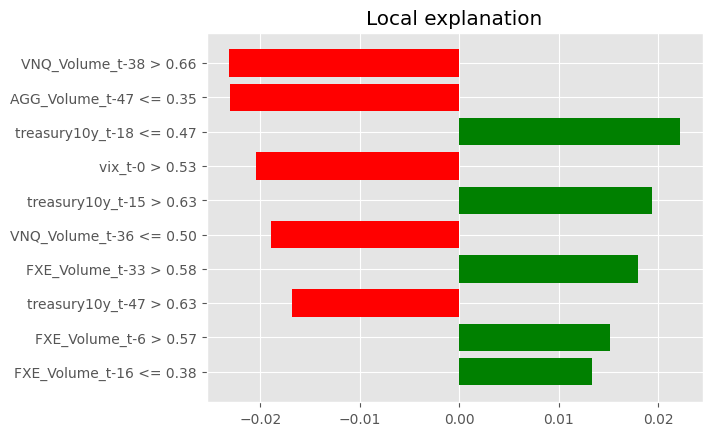

In [ ]:
idx = 81
print(f'Explanation as of date: {train_date_index[idx]}')
run_lime_explain(best_model, idx=idx)

### Model 1

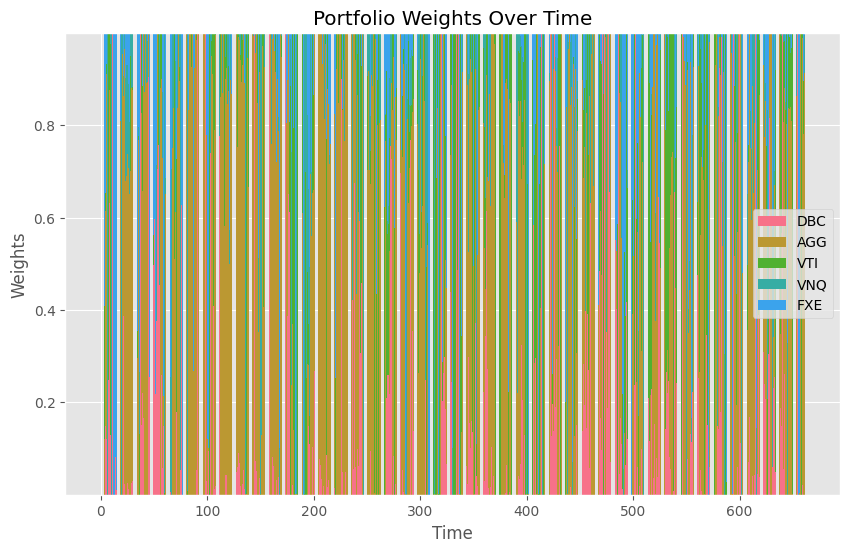

In [ ]:
MARKOWITZ_TIME_WINDOW = 5
train_weights = markowitz_weights(Y_train_scaled, train_predictions_bestmodel_scaled,
                                 average_return_with_history=False,
                                  risk_free_rates=risk_free_train, # RF rate is annual, make it weekly
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  )
plot_portfolio_weights(train_weights)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

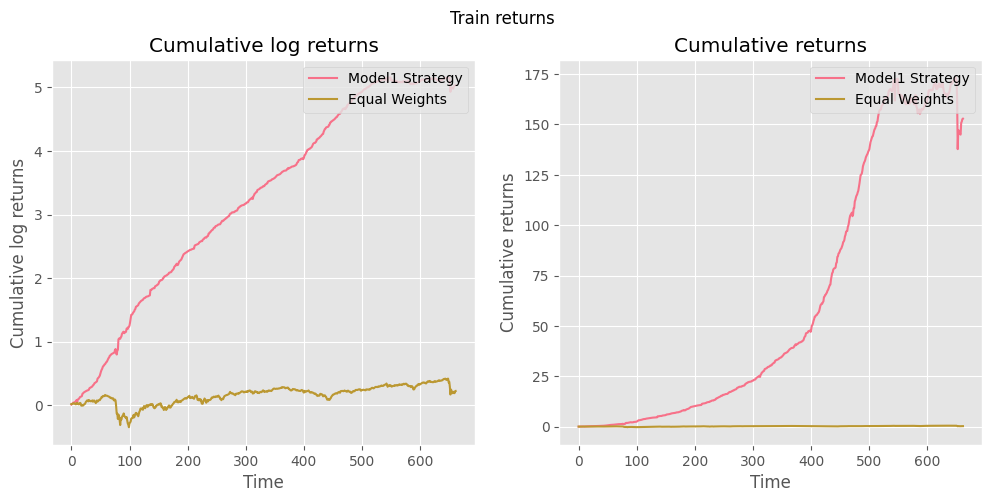

In [ ]:
train_ret_df = calculate_and_plot_returns(Y_train_scaled, train_weights, equal_weights_train,
                                          plot_title='Train returns',
                                          time_axis=train_date_index, return_df=True)
train_ret_df.to_csv('Model1_Tuned_Train.csv')
files.download('Model1_Tuned_Train.csv')

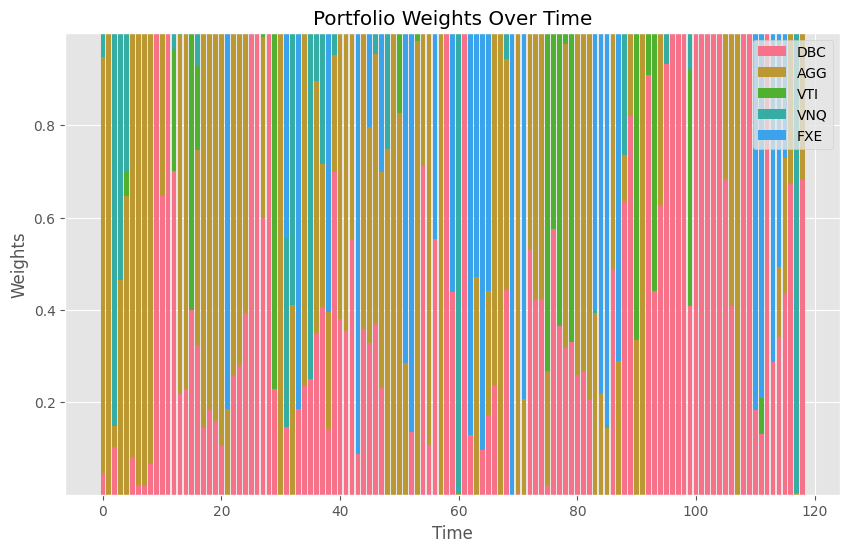

In [ ]:
# Test
test_weights = markowitz_weights(Y_test_scaled, test_predictions_bestmodel_scaled,
                                 average_return_with_history=False,
                                  risk_free_rates=risk_free_test, # RF rate is annual, make it weekly
                                  time_window=MARKOWITZ_TIME_WINDOW,
                                  diversification_penalty_coeff=0, deviation_penalty_coeff=0
                                  )
plot_portfolio_weights(test_weights)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

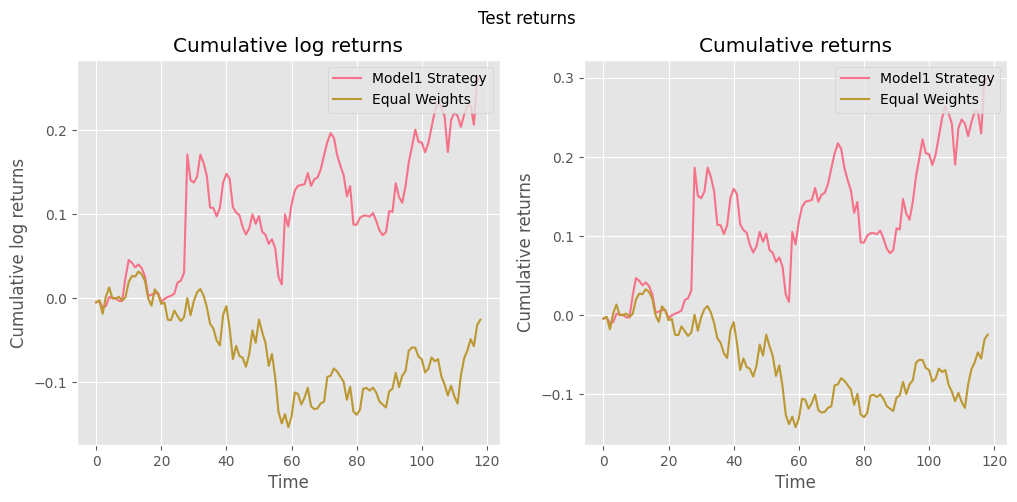

In [ ]:
test_ret_df = calculate_and_plot_returns(Y_test_scaled, test_weights, equal_weights_test,
                                          plot_title='Test returns',
                                          time_axis=test_date_index, return_df=True)
test_ret_df.to_csv('Model1_Tuned_Test.csv')
files.download('Model1_Tuned_Test.csv')